# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
!pip install --upgrade pandas  # conda did not work. pip upgrade needs to be executed each time after restarting the workspace. A kernel restart is necessary after the pip upgrade.
#!pip install -U matplotlib
!pip install --upgrade seaborn

Requirement already up-to-date: pandas in /opt/conda/lib/python3.6/site-packages (1.1.5)
Requirement already up-to-date: seaborn in /opt/conda/lib/python3.6/site-packages (0.11.2)


In [2]:
!pip uninstall statsmodels -y
!pip install numpy scipy patsy pandas
!pip install statsmodels
!pip install --upgrade sklearn
!pip install scikit-learn --upgrade

Uninstalling statsmodels-0.12.2:
  Successfully uninstalled statsmodels-0.12.2
  Using cached https://files.pythonhosted.org/packages/0d/7b/c17815648dc31396af865b9c6627cc3f95705954e30f61106795361c39ee/statsmodels-0.12.2-cp36-cp36m-manylinux1_x86_64.whl
Requirement already up-to-date: sklearn in /opt/conda/lib/python3.6/site-packages (0.0.post1)
Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.6/site-packages (0.24.2)


In [3]:
#!pip install pipreqsnb
#!pipreqsnb .

In [4]:
import pandas as pd
import numpy as np
import math
import json
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
#% matplotlib notebook

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [5]:
# models
import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [6]:
pd.__version__, sns.__version__

('1.1.5', '0.11.2')

In [7]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Expore Data And First Cleaning

## Portfolio

In [8]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [9]:
portfolio.shape

(10, 6)

In [10]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [11]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [12]:
#portfolio.duplicated()

the portfolio data contains 10 rows with all non-null values. For further exploration the lists contained in column 'channels' need to be separated in to individual columns.

In [13]:
pd.get_dummies(portfolio['channels'].explode()).sum(level=0)  # as suggested on https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies


,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [14]:
# as each row contains "1" for emails, email will be treated as the default and the column email is removed to avoid collinearity effects
portfolio = portfolio.join(pd.get_dummies(portfolio['channels'].explode(), drop_first=True).sum(level=0), rsuffix='_r')
portfolio = portfolio.drop(['channels'], axis=1)

In [15]:
portfolio.duplicated().any()

False

In [16]:
# as profile also contains a column named 'id', column is renamed to avoid confusing features. Use 'offer_id' as in transcript
portfolio = portfolio.rename(columns={'id': 'offer_id'})
portfolio

,reward,difficulty,duration,offer_type,offer_id,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,0,1


In [17]:
portfolio['reward'].sort_values().unique(), portfolio['difficulty'].sort_values().unique()

(array([ 0,  2,  3,  5, 10]), array([ 0,  5,  7, 10, 20]))

In [18]:
round((portfolio['reward'] / portfolio['difficulty']).sort_values(), 2).unique()

array([0.2 , 0.25, 0.43, 1.  ,  nan])

Except for the bogo offer (100% discount), there are discounts of 20%, 25% and 43% (if maxed out by just fulfilling the difficulty). Informational offer has 0% discount. 

## Profile

In [19]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [20]:
profile.shape

(17000, 5)

In [21]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [22]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [23]:
profile.duplicated().any()

False

In [24]:
profile[profile['age']==118].shape[0], profile[profile['gender'].isnull()].shape[0], profile[profile['income'].isnull()].shape[0]

(2175, 2175, 2175)

columns gender and income contain same number of null values, other columns are non-null at first glimpse. However, the age column contains, as stated in the project description, max values of 118 instead of NaNs. 'became_member_on' has been converted to datetime and will probably be replaced with the number of membership years. There are no duplicate rows.
Look into the 'age = 118' rows:

In [25]:
profile.loc[(profile['age']==118) & ((profile['gender'].isnull() == False) | (profile['income'].isnull() == False))].shape[0]

0

All of the 2175 rows that lack the age information, do not contain information on gender nor income. As in rows without demographic information and only the joining date will not be too useful in our analysis and losing 12,8% of the customer rows seems reasonable, we drop these rows (knowing that joining date may be useful for some extended evaluation):

In [26]:
profile = profile[profile['age']!=118]

In [27]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [28]:
profile.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [29]:
profile['id'].nunique()

14825

M    8484
F    6129
O     212
Name: gender, dtype: int64

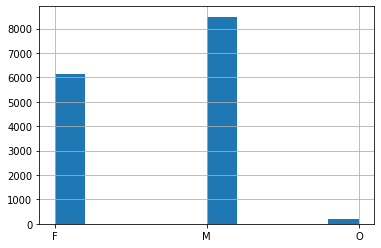

In [30]:
profile['gender'].hist()
profile['gender'].value_counts()

In [31]:
profile['gender'].value_counts()[0]/profile.shape[0], profile['gender'].value_counts()[1]/profile.shape[0], profile['gender'].value_counts()[2]/profile.shape[0], 

(0.5722765598650927, 0.4134232715008432, 0.014300168634064081)

genders represented in dataset are imbalanced. We will dummy the gender,  dropping 'O' because of its low representation and to avoid high correlation between gender columns. Ethics of doing so not discussed here.
('O' could have been represented as 0 in both 'female' and 'male' columns, if used)

In [32]:
#profile[['female', 'male', 'other']] = pd.get_dummies(profile['gender'])
#profile = profile.drop(['gender', 'other'], axis=1)
profile = profile[profile['gender'] != 'O']
profile[['female', 'male']] = pd.get_dummies(profile['gender'])
profile = profile.drop(['gender', 'male'], axis=1)
profile

,age,id,became_member_on,income,female
1,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1
3,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1
5,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,0
8,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,0
...,...,...,...,...,...
16995,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,1
16996,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,0
16997,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,0
16998,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,1


In [33]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [34]:
profile['became_member_on'].min(), profile['became_member_on'].max()

(Timestamp('2013-07-29 00:00:00'), Timestamp('2018-07-26 00:00:00'))

In [35]:
reference_date = profile['became_member_on'].max() + timedelta(days=7)
reference_date

Timestamp('2018-08-02 00:00:00')

In [36]:
profile['membership months'] = (reference_date - profile['became_member_on']).astype('timedelta64[M]').astype('int64')
profile = profile.drop(['became_member_on'], axis=1)

<AxesSubplot:>

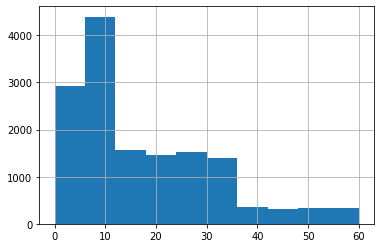

In [37]:
profile['membership months'].hist()

the membership time distribution is skewed to short memberships within the dataset

<AxesSubplot:>

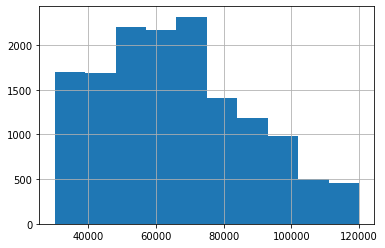

In [38]:
profile.income.hist()

the income distribution is skewed to the lower incomes

In [39]:
profile.head()

,age,id,income,female,membership months
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,12
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,14
5,68,e2127556f4f64592b11af22de27a7932,70000.0,0,3
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,5
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,8


No nulls left in the profile dataset.
Rename column 'id' to 'customer_id' to be specific:

In [40]:
profile = profile.rename(columns={'id': 'customer_id'})

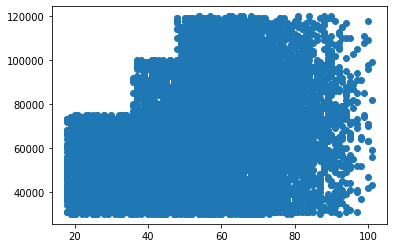

In [41]:
plt.scatter(profile['age'], profile['income'])

weird pattern but probably due to random value creation for the dataset. nothing to be cleaned.

## Transcript

In [42]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [43]:
value_df = pd.json_normalize(transcript['value'])  # as proposed on https://stackoverflow.com/questions/46391291/how-to-convert-json-data-inside-a-pandas-column-into-new-columns

In [44]:
value_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   offer id  134002 non-null  object 
 1   amount    138953 non-null  float64
 2   offer_id  33579 non-null   object 
 3   reward    33579 non-null   float64
dtypes: float64(2), object(2)
memory usage: 9.4+ MB


In [45]:
value_df[~value_df['offer_id'].isnull() & ~value_df['offer id'].isnull()].shape[0]

0

After the extraction, there are 2 'offer_id' columns: 'offer_id' and 'offer id'. As there is no overlap, we will simply copy all values from 'offer id' to 'offer_id' and then drop 'offer id'

In [46]:
value_df.loc[value_df['offer_id'].isnull(), 'offer_id'] = value_df['offer id']
value_df = value_df.drop(['offer id'], axis=1)
value_df.head()

,amount,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [47]:
value_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   amount    138953 non-null  float64
 1   offer_id  167581 non-null  object 
 2   reward    33579 non-null   float64
dtypes: float64(2), object(1)
memory usage: 7.0+ MB


check: the number of non-null values in 'offer_id' is now equivalent to the sum of the two columns before the operation.
Join value_df with transcript and drop original 'value' column:

In [48]:
transcript = transcript.drop(['value'], axis=1)
transcript = transcript.join(value_df, rsuffix='_r')
transcript.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [49]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [50]:
transcript.duplicated().sum()

397

In [51]:
transcript[transcript.duplicated()]['event'].value_counts()

offer completed    397
Name: event, dtype: int64

There are 397 duplicates which are all events of type 'offer completed'. This could be due to multiple purchases of the same item/offer by the same customer within one hour or if the duplicates should be removed. However, for our evaluation we will remove that small subset (about 400 out of about 139000).

In [52]:
transcript = transcript.drop_duplicates()
transcript.shape

(306137, 6)

Rename 'person' to 'customer_id' for consistency:

In [53]:
transcript = transcript.rename(columns={'person': 'customer_id'})

## Merge into 1 dataset

In [54]:
df = pd.merge(transcript, profile, on='customer_id')
df.head()

,customer_id,event,time,amount,offer_id,reward,age,income,female,membership months
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,100000.0,1,14
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,100000.0,1,14
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,NaN,75,100000.0,1,14
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,75,100000.0,1,14
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,NaN,75,100000.0,1,14


In [55]:
df = pd.merge(df, portfolio, how='left', on='offer_id')
df.head()

,customer_id,event,time,amount,offer_id,reward_x,age,income,female,membership months,reward_y,difficulty,duration,offer_type,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,100000.0,1,14,5.0,5.0,7.0,bogo,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,100000.0,1,14,5.0,5.0,7.0,bogo,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,NaN,75,100000.0,1,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,75,100000.0,1,14,5.0,5.0,7.0,bogo,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,NaN,75,100000.0,1,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df.shape

(268423, 17)

rename rewards to make specific

In [57]:
df[~df['reward_x'].isnull()]['event'].value_counts()

offer completed    31575
Name: event, dtype: int64

In [58]:
df[~df['reward_y'].isnull()]['event'].value_counts()

offer received     65585
offer viewed       49087
offer completed    31575
Name: event, dtype: int64

In [59]:
df.query('event=="offer completed" & reward_x==reward_y').shape[0]

31575

'reward_x' is identical to 'reward_y' for all rows of 'event' "offer received" and is NaN for all other events. Thus 'reward_x' can be dropped and 'reward_y' is renamed to 'reward':

In [60]:
df = df.drop(['reward_x'], axis=1)
df = df.rename(columns={'reward_y': 'reward'})

In [61]:
df.head(10)

,customer_id,event,time,amount,offer_id,age,income,female,membership months,reward,difficulty,duration,offer_type,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,100000.0,1,14,5.0,5.0,7.0,bogo,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,100000.0,1,14,5.0,5.0,7.0,bogo,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,75,100000.0,1,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,100000.0,1,14,5.0,5.0,7.0,bogo,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,75,100000.0,1,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,75,100000.0,1,14,0.0,0.0,3.0,informational,1.0,1.0,0.0
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,NaN,5a8bc65990b245e5a138643cd4eb9837,75,100000.0,1,14,0.0,0.0,3.0,informational,1.0,1.0,0.0
7,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,19.67,NaN,75,100000.0,1,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,29.72,NaN,75,100000.0,1,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,23.93,NaN,75,100000.0,1,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
df.describe()

,time,amount,age,income,female,membership months,reward,difficulty,duration,mobile,social,web
count,268423.000000,122176.000000,268423.000000,268423.000000,268423.000000,268423.000000,146247.000000,146247.000000,146247.000000,146247.000000,146247.000000,146247.000000
mean,366.614903,13.984628,53.834396,64349.187663,0.420754,18.860515,4.442854,7.882958,6.621927,0.917735,0.659316,0.806629
std,200.368088,31.828472,17.571553,21271.958211,0.493681,14.112490,3.374746,5.034415,2.132900,0.274769,0.473941,0.394943
min,0.000000,0.050000,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,186.000000,3.630000,41.000000,48000.000000,0.000000,8.000000,2.000000,5.000000,5.000000,1.000000,0.000000,1.000000
50%,408.000000,10.760000,55.000000,62000.000000,0.000000,15.000000,5.000000,10.000000,7.000000,1.000000,1.000000,1.000000
75%,528.000000,19.130000,66.000000,78000.000000,1.000000,28.000000,5.000000,10.000000,7.000000,1.000000,1.000000,1.000000
max,714.000000,1062.280000,101.000000,120000.000000,1.000000,60.000000,10.000000,20.000000,10.000000,1.000000,1.000000,1.000000


In [63]:
df['time'].max()/24

29.75

The test run for about 30 days, about 1 month

# Data Preparation

In [64]:
df2 = df.copy()

In [65]:
df2['valid until'] = df2[df2['event'] == 'offer received']['time'] + df2[df2['event'] == 'offer received']['duration']*24

def event_within_validity(df, row, event):
    customer = row['customer_id']
    offer = row['offer_id']
    df = df.query('customer_id == @customer  & offer_id == @offer & event == @event')
    #df = df[(df['customer_id'] == customer_id)  & (df['offer_id'] == offer_id) & (df['event'] == event)]
    start = row['time']
    end = row['valid until']
    view_time = df['time']
    for view in view_time:
        if (start <= view) and (view <= end):
            return True
    
    return False

df2['offer viewed in time'] = df2[df2['event'] == 'offer received'][['customer_id', 'time', 'valid until', 'offer_id']].apply(lambda row: event_within_validity(df2, row, 'offer viewed'), axis=1)
df2

above function to check whether offer has been "viewed" within validity timeframe runs for too long on full dataset. Thus we just assume that if an offer has been recorded as "viewed", it was within the range of validity. Same for "offer completed"

In [66]:
viewed_df = df2[df2['event'] == 'offer viewed'][['customer_id', 'offer_id']]
df2['offer viewed'] = np.nan
df2['offer viewed'] = (df2['customer_id'].isin(viewed_df['customer_id']) & df2['offer_id'].isin(viewed_df['offer_id'])).astype('int')

completed_df = df2[df2['event'] == 'offer completed'][['customer_id', 'offer_id']]
df2['offer completed'] = np.nan
df2['offer completed'] = (df2['customer_id'].isin(completed_df['customer_id']) & df2['offer_id'].isin(completed_df['offer_id'])).astype('int')
df2

,customer_id,event,time,amount,offer_id,age,income,female,membership months,reward,difficulty,duration,offer_type,mobile,social,web,valid until,offer viewed,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,100000.0,1,14,5.0,5.0,7.0,bogo,1.0,0.0,1.0,168.0,1,1
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,100000.0,1,14,5.0,5.0,7.0,bogo,1.0,0.0,1.0,NaN,1,1
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,75,100000.0,1,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,100000.0,1,14,5.0,5.0,7.0,bogo,1.0,0.0,1.0,NaN,1,1
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,75,100000.0,1,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268418,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,504,NaN,3f207df678b143eea3cee63160fa8bed,47,94000.0,0,9,0.0,0.0,4.0,informational,1.0,0.0,1.0,NaN,1,0
268419,9fcbff4f8d7241faa4ab8a9d19c8a812,offer received,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,47,94000.0,0,9,10.0,10.0,5.0,bogo,1.0,1.0,1.0,696.0,1,0
268420,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,47,94000.0,0,9,10.0,10.0,5.0,bogo,1.0,1.0,1.0,NaN,1,0
268421,3045af4e98794a04a5542d3eac939b1f,offer received,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,58,78000.0,1,21,10.0,10.0,5.0,bogo,1.0,1.0,1.0,696.0,1,0


In [67]:
df3 = df2[df2['event'].isin(['offer received', 'transaction'])]
df3.loc[df3['event'] == 'transaction', 'offer_type'] = 'transaction'
df3 = df3.drop(['offer_id', 'event', 'duration'], axis=1)
df3 = df3.rename(columns={'offer_type': 'type'})
df3.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,customer_id,time,amount,age,income,female,membership months,reward,difficulty,type,mobile,social,web,valid until,offer viewed,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,75,100000.0,1,14,5.0,5.0,bogo,1.0,0.0,1.0,168.0,1,1
2,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,75,100000.0,1,14,NaN,NaN,transaction,NaN,NaN,NaN,NaN,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,75,100000.0,1,14,NaN,NaN,transaction,NaN,NaN,NaN,NaN,0,0
5,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,75,100000.0,1,14,0.0,0.0,informational,1.0,1.0,0.0,240.0,1,0
7,78afa995795e4d85b5d9ceeca43f5fef,222,19.67,75,100000.0,1,14,NaN,NaN,transaction,NaN,NaN,NaN,NaN,0,0


# More Detailed Analysis and Cleaning

Now that we have built an understanding of the data, done some cleaning and have merged everything to a single dataframe, we can start working with the data. We can go into some deeper analysis and visualize findings.

In [68]:
df3.describe()

,time,amount,age,income,female,membership months,reward,difficulty,mobile,social,web,valid until,offer viewed,offer completed
count,187761.000000,122176.000000,187761.000000,187761.000000,187761.000000,187761.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,187761.000000,187761.000000
mean,364.368958,13.984628,53.288580,63094.279430,0.409233,19.286439,4.200778,7.715499,0.898956,0.598765,0.799741,488.864466,0.346787,0.231193
std,201.323402,31.828472,17.766384,21096.859661,0.491694,14.326498,3.399038,5.545371,0.301390,0.490152,0.400197,203.315589,0.475948,0.421597
min,0.000000,0.050000,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.000000,0.000000,0.000000
25%,180.000000,3.630000,40.000000,47000.000000,0.000000,8.000000,2.000000,5.000000,1.000000,0.000000,1.000000,336.000000,0.000000,0.000000
50%,402.000000,10.760000,54.000000,61000.000000,0.000000,16.000000,5.000000,10.000000,1.000000,1.000000,1.000000,528.000000,0.000000,0.000000
75%,528.000000,19.130000,66.000000,75000.000000,1.000000,29.000000,5.000000,10.000000,1.000000,1.000000,1.000000,672.000000,1.000000,0.000000
max,714.000000,1062.280000,101.000000,120000.000000,1.000000,60.000000,10.000000,20.000000,1.000000,1.000000,1.000000,816.000000,1.000000,1.000000


In [69]:
df3['reward'].max(), df3['difficulty'].max()

(10.0, 20.0)

In [70]:
df3[df3['type'] == 'transaction']['amount'].describe()

count    122176.000000
mean         13.984628
std          31.828472
min           0.050000
25%           3.630000
50%          10.760000
75%          19.130000
max        1062.280000
Name: amount, dtype: float64

51.25874999999999

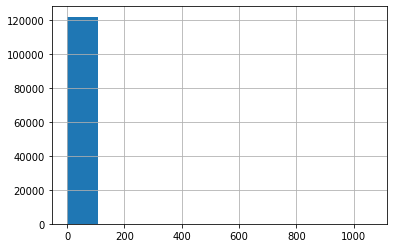

In [71]:
# amount is only non-null for transactions
df3[df3['type'] == 'transaction']['amount'].hist()
np.percentile(df3[df3['type'] == 'transaction']['amount'], 99.5)

in this evaluation we will focus on the about 99.5% of customers whose amount is 50 or less, assuming that the few customers buying bigger amounts would most likely do so without having received offers (negligible savings with bogos, discounts between 20% and 1%). This needs to be investigated in another evaluation.

In [72]:
df4 = df3[(df3['amount'] < 200) | df3['amount'].isnull()]

In [73]:
df4.head()

,customer_id,time,amount,age,income,female,membership months,reward,difficulty,type,mobile,social,web,valid until,offer viewed,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,75,100000.0,1,14,5.0,5.0,bogo,1.0,0.0,1.0,168.0,1,1
2,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,75,100000.0,1,14,NaN,NaN,transaction,NaN,NaN,NaN,NaN,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,75,100000.0,1,14,NaN,NaN,transaction,NaN,NaN,NaN,NaN,0,0
5,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,75,100000.0,1,14,0.0,0.0,informational,1.0,1.0,0.0,240.0,1,0
7,78afa995795e4d85b5d9ceeca43f5fef,222,19.67,75,100000.0,1,14,NaN,NaN,transaction,NaN,NaN,NaN,NaN,0,0


<AxesSubplot:>

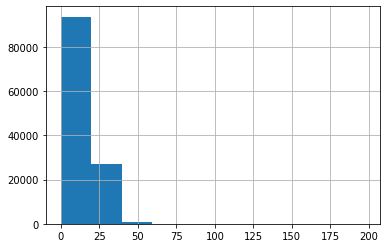

In [74]:
# amount is only non-null for transactions
df4[df4['type'] == 'transaction']['amount'].hist()

<AxesSubplot:>

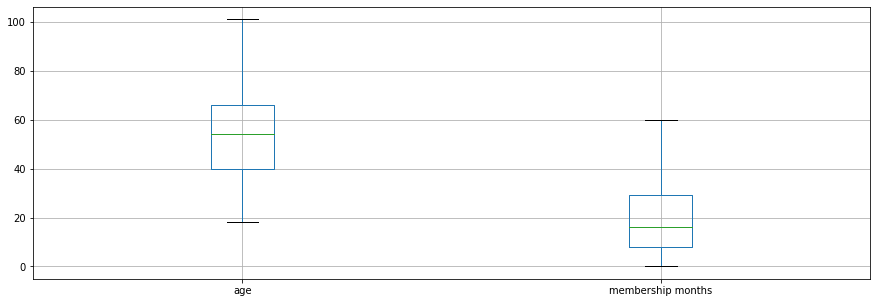

In [75]:
fig, ax = plt.subplots(figsize=(15,5))
#df4.drop(['income', 'time', 'valid until', 'amount'], axis=1).boxplot()
df4[['age', 'membership months']].boxplot()
#df4[['reward', 'difficulty']].boxplot()

In [76]:
df4[df4['type'] != 'transaction'].isnull().any()

customer_id          False
time                 False
amount                True
age                  False
income               False
female               False
membership months    False
reward               False
difficulty           False
type                 False
mobile               False
social               False
web                  False
valid until          False
offer viewed         False
offer completed      False
dtype: bool

In [77]:
df4[df4['type'] == 'transaction'].isnull().any()

customer_id          False
time                 False
amount               False
age                  False
income               False
female               False
membership months    False
reward                True
difficulty            True
type                 False
mobile                True
social                True
web                   True
valid until           True
offer viewed         False
offer completed      False
dtype: bool

# Feature Engineering

In [78]:
df = df4.copy()

In [79]:
df[['bogo', 'discount', 'informational', 'transaction']] = pd.get_dummies(df['type'])

In [80]:
df['rel discount'] = round(df['reward'] / df['difficulty'], 2)
#df[df['rel discount'].isnull()]['rel discount'] = 0
df.loc[df['rel discount'].isnull(), 'rel discount'] = 0
df[(df['type']=='discount') & (df['rel discount']==0)].shape[0], df[(df['type']=='discount') & (df['rel discount']==1)].shape[0]

(0, 0)

In [81]:
# dummy rel discount, 0% = information, 100% = 
df[['0.00', 'discount 0.20', 'discount 0.25', 'discount 0.43', '1.00']] = pd.get_dummies(df['rel discount'])
df = df.drop(['type', '0.00', '1.00', 'discount', 'rel discount'], axis=1)
df

,customer_id,time,amount,age,income,female,membership months,reward,difficulty,mobile,...,web,valid until,offer viewed,offer completed,bogo,informational,transaction,discount 0.20,discount 0.25,discount 0.43
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,75,100000.0,1,14,5.0,5.0,1.0,...,1.0,168.0,1,1,1,0,0,0,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,75,100000.0,1,14,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,1,0,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,75,100000.0,1,14,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,1,0,0,0
5,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,75,100000.0,1,14,0.0,0.0,1.0,...,0.0,240.0,1,0,0,1,0,0,0,0
7,78afa995795e4d85b5d9ceeca43f5fef,222,19.67,75,100000.0,1,14,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268415,8578196a074a4f328976e334fa9383a3,576,NaN,48,58000.0,0,1,2.0,10.0,1.0,...,1.0,744.0,1,0,0,0,0,1,0,0
268416,8578196a074a4f328976e334fa9383a3,702,4.62,48,58000.0,0,1,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,1,0,0,0
268417,9fcbff4f8d7241faa4ab8a9d19c8a812,504,NaN,47,94000.0,0,9,0.0,0.0,1.0,...,1.0,600.0,1,0,0,1,0,0,0,0
268419,9fcbff4f8d7241faa4ab8a9d19c8a812,576,NaN,47,94000.0,0,9,10.0,10.0,1.0,...,1.0,696.0,1,0,1,0,0,0,0,0


In [82]:
df5 = df.copy()

In [83]:
df[df['transaction'] == 0]

,customer_id,time,amount,age,income,female,membership months,reward,difficulty,mobile,...,web,valid until,offer viewed,offer completed,bogo,informational,transaction,discount 0.20,discount 0.25,discount 0.43
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,75,100000.0,1,14,5.0,5.0,1.0,...,1.0,168.0,1,1,1,0,0,0,0,0
5,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,75,100000.0,1,14,0.0,0.0,1.0,...,0.0,240.0,1,0,0,1,0,0,0,0
10,78afa995795e4d85b5d9ceeca43f5fef,408,NaN,75,100000.0,1,14,10.0,10.0,1.0,...,0.0,576.0,1,1,1,0,0,0,0,0
12,78afa995795e4d85b5d9ceeca43f5fef,504,NaN,75,100000.0,1,14,5.0,5.0,1.0,...,1.0,624.0,1,1,1,0,0,0,0,0
18,e2127556f4f64592b11af22de27a7932,0,NaN,68,70000.0,0,3,2.0,10.0,1.0,...,1.0,168.0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268413,8578196a074a4f328976e334fa9383a3,504,NaN,48,58000.0,0,1,10.0,10.0,1.0,...,1.0,624.0,1,0,1,0,0,0,0,0
268415,8578196a074a4f328976e334fa9383a3,576,NaN,48,58000.0,0,1,2.0,10.0,1.0,...,1.0,744.0,1,0,0,0,0,1,0,0
268417,9fcbff4f8d7241faa4ab8a9d19c8a812,504,NaN,47,94000.0,0,9,0.0,0.0,1.0,...,1.0,600.0,1,0,0,1,0,0,0,0
268419,9fcbff4f8d7241faa4ab8a9d19c8a812,576,NaN,47,94000.0,0,9,10.0,10.0,1.0,...,1.0,696.0,1,0,1,0,0,0,0,0


## Analyse Funnel

In [84]:
offer_cols = ['bogo', 'informational', 'discount 0.20', 'discount 0.25', 'discount 0.43']
offers_count = (df[offer_cols].sum(axis=1)).sum()
offers_viewed_count = (df['offer viewed'] == 1).sum()
offers_completed_count = (df['offer completed'] == 1).sum()
informational_count = (df['informational'] == 1).sum()

In [85]:
offers_count, offers_viewed_count, offers_completed_count, informational_count

(65585, 65113, 43409, 13105)

In [86]:
offers_viewed_count / offers_count, offers_completed_count / offers_viewed_count, offers_completed_count / offers_count

(0.9928032324464435, 0.6666717859720793, 0.6618739040939239)

In [87]:
offers_completed_count / (offers_count - informational_count)

0.8271532012195122

In [88]:
#analyse sent vs completed for different offer types except for informaitonal:
bogo = df[df['bogo'] == 1]
discount43 = df[df['discount 0.43'] == 1]
discount25 = df[df['discount 0.25'] == 1]
discount20 = df[df['discount 0.20'] == 1]

print(f"bogo: {(bogo['offer completed'] ==1).sum()} - {(bogo['offer completed'] ==1).sum() / bogo.shape[0]}")
print(f"discount 43: {(discount43['offer completed'] ==1).sum()} - {(discount43['offer completed'] ==1).sum() / discount43.shape[0]}")
print(f"discount 25: {(discount25['offer completed'] ==1).sum()} - {(discount25['offer completed'] ==1).sum() / discount25.shape[0]}")
print(f"discount 20: {(discount20['offer completed'] ==1).sum()} - {(discount20['offer completed'] ==1).sum() / discount20.shape[0]}")

bogo: 21523 - 0.8220219226215484
discount 43: 5658 - 0.8621057443242419
discount 25: 5290 - 0.798249585030934
discount 20: 10938 - 0.8345159075303273


- 99% of all offers are viewes (including informational)
- 83% of all offers are completed (if excluding informational, which has no record for completion)
    All offers have almost the same acceptance rate. 25% discount has lowest completion rate. Lower than 20% discount, which is 'cheaper' for the company -> suggest A/B test dropping the 25% discount, if further analysis shows that demographic subgroups show similar results (Simpson's Paradox!). Not investigated here

array([[<AxesSubplot:title={'center':'size'}>]], dtype=object)

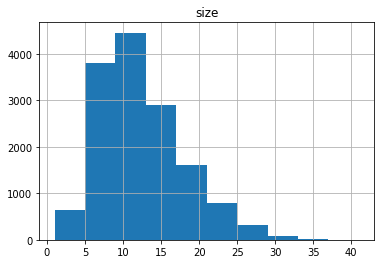

In [89]:
number_of_offers_per_customer_no_info = df[df['informational'] == 0].groupby('customer_id', as_index=False).size()
number_of_offers_per_customer_no_info.hist()

array([[<AxesSubplot:title={'center':'size'}>]], dtype=object)

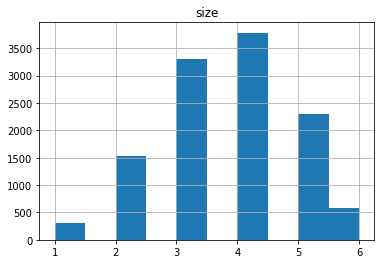

In [90]:
rows_completed = df[df['offer completed'] == 1]
number_of_offers_completed_per_customer = rows_completed.groupby('customer_id', as_index=False).size()
number_of_offers_completed_per_customer.hist()

count    11807.000000
mean         0.323903
std          0.142414
min          0.055556
25%          0.222222
50%          0.300000
75%          0.400000
max          0.857143
Name: completed rel, dtype: float64

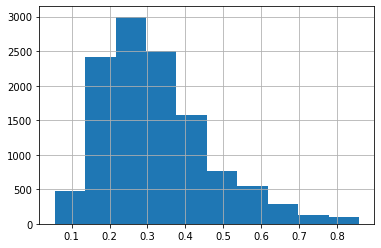

In [91]:
number_of_offered_and_completed = number_of_offers_per_customer_no_info.merge(number_of_offers_completed_per_customer, how='left', on='customer_id')
number_of_offered_and_completed.rename(columns={'size_x': 'offers', 'size_y': 'completed'}, inplace=True)
#number_of_offered_and_completed[number_of_offered_and_completed['completed']=='NaN']#['offers'].value_counts()
number_of_offered_and_completed['completed rel'] = number_of_offered_and_completed['completed'] / number_of_offered_and_completed['offers']
number_of_offered_and_completed['completed rel'].hist()
number_of_offered_and_completed['completed rel'].describe()

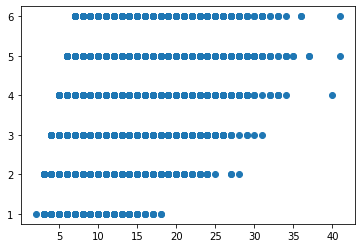

In [92]:
plt.scatter(number_of_offered_and_completed['offers'], number_of_offered_and_completed['completed'])

<AxesSubplot:>

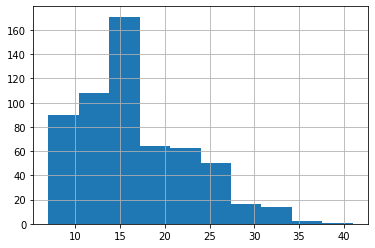

In [93]:
number_of_offered_and_completed[number_of_offered_and_completed['completed']==6]['offers'].hist()

50% of the customers complete between 22% and 40% of the offers that they receive but 6 at max, even when offered up to 40 discounts.

## Correlation analysis

In [94]:
df.columns

Index(['customer_id', 'time', 'amount', 'age', 'income', 'female',
       'membership months', 'reward', 'difficulty', 'mobile', 'social', 'web',
       'valid until', 'offer viewed', 'offer completed', 'bogo',
       'informational', 'transaction', 'discount 0.20', 'discount 0.25',
       'discount 0.43'],
      dtype='object')

In [95]:
cols = ['offer completed', 'offer viewed', 'bogo', 'informational', 'discount 0.20', 'discount 0.25', 'discount 0.43', 'reward', 'difficulty', 'age', 'income', 'female', 'membership months', 'mobile', 'social', 'web']
cols.reverse()
df = df[cols]

In [96]:
def nice_corr_matrix(df, save=False):
    """creates a nice correlation matrix plot (triangle)
    
    """
    ## nice correlation matrix plot inspired by: https://lost-stats.github.io/Presentation/Figures/heatmap_colored_correlation_matrix.html
    # Create the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle; True = do NOT show
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    # More details at https://seaborn.pydata.org/generated/seaborn.heatmap.html
    sns.heatmap(
        corr,          # The data to plot
        mask=mask,     # Mask some cells
        cmap=cmap,     # What colors to plot the heatmap as
        annot=True,    # Should the values be plotted in the cells?
        vmax=1.0,       # The maximum value of the legend. All higher vals will be same color
        vmin=-1.0,      # The minimum value of the legend. All lower vals will be same color
        center=0,      # The center value of the legend. With divergent cmap, where white is
        square=True,   # Force cells to be square
        linewidths=.5, # Width of lines that divide cells
        cbar_kws={"shrink": .5},  # Extra kwargs for the legend; in this case, shrink by 50%
        fmt=".2f"      # decimals display format
    )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    
    if save:
        f.savefig('heatmap_colored_correlation_matrix.png') # save as png

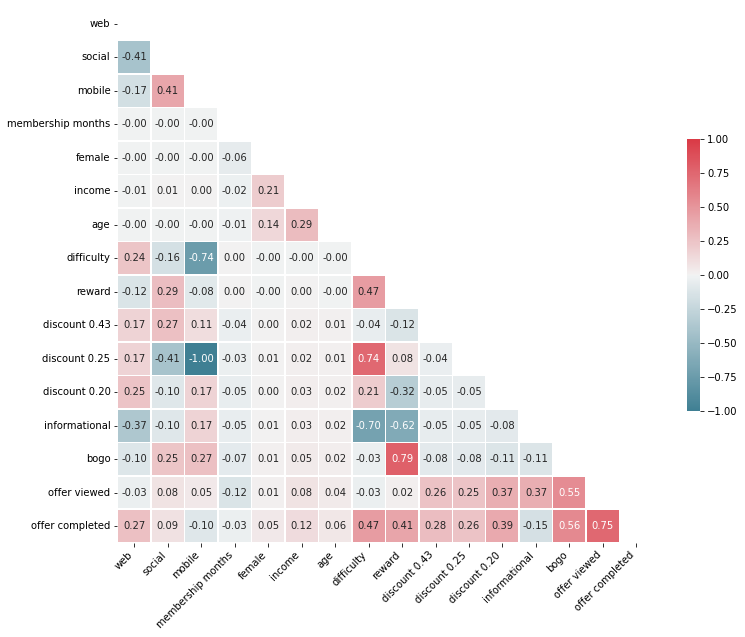

In [97]:
nice_corr_matrix(df)

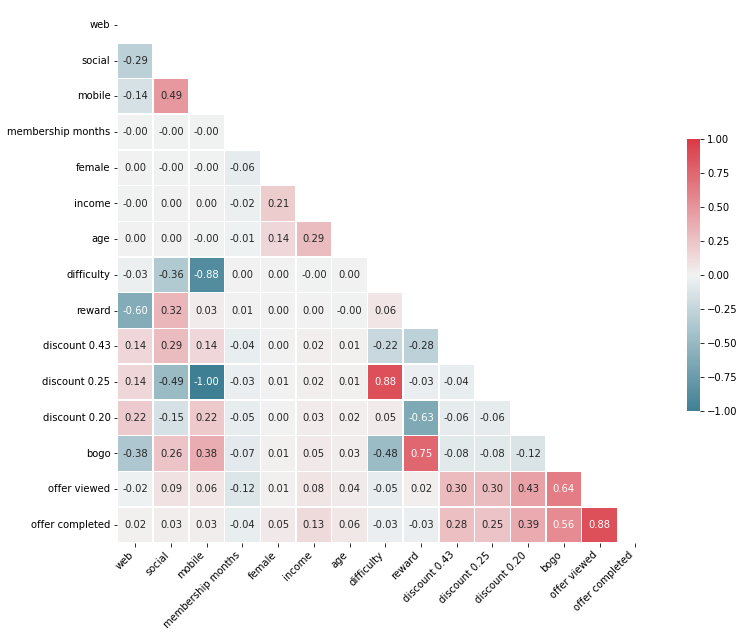

In [98]:
df_no_inf = df[df['informational'] == 0].drop(['informational'], axis=1)
nice_corr_matrix(df_no_inf)

- No strong correlations between "offers viewed" and demographic data or channels. If an offer is viewed or not, seems to depend on the offer tpye, with bogo being the most likely one to be viewed.
- Strong correlation between "offer viewed" and "offer completed", as expected.

In [99]:
#sns.pairplot(df)

# Modeling

In [100]:
df = df5.copy()
df.head()

,customer_id,time,amount,age,income,female,membership months,reward,difficulty,mobile,...,web,valid until,offer viewed,offer completed,bogo,informational,transaction,discount 0.20,discount 0.25,discount 0.43
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,75,100000.0,1,14,5.0,5.0,1.0,...,1.0,168.0,1,1,1,0,0,0,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,75,100000.0,1,14,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,1,0,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,75,100000.0,1,14,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,1,0,0,0
5,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,75,100000.0,1,14,0.0,0.0,1.0,...,0.0,240.0,1,0,0,1,0,0,0,0
7,78afa995795e4d85b5d9ceeca43f5fef,222,19.67,75,100000.0,1,14,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,1,0,0,0


In [101]:
df = df[df['informational'] == 0].drop(['informational'], axis=1)
df = df[df['transaction'] == 0].drop(['transaction'], axis=1)
df.head()

,customer_id,time,amount,age,income,female,membership months,reward,difficulty,mobile,social,web,valid until,offer viewed,offer completed,bogo,discount 0.20,discount 0.25,discount 0.43
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,75,100000.0,1,14,5.0,5.0,1.0,0.0,1.0,168.0,1,1,1,0,0,0
10,78afa995795e4d85b5d9ceeca43f5fef,408,NaN,75,100000.0,1,14,10.0,10.0,1.0,1.0,0.0,576.0,1,1,1,0,0,0
12,78afa995795e4d85b5d9ceeca43f5fef,504,NaN,75,100000.0,1,14,5.0,5.0,1.0,1.0,1.0,624.0,1,1,1,0,0,0
18,e2127556f4f64592b11af22de27a7932,0,NaN,68,70000.0,0,3,2.0,10.0,1.0,0.0,1.0,168.0,1,1,0,1,0,0
23,e2127556f4f64592b11af22de27a7932,408,NaN,68,70000.0,0,3,5.0,5.0,1.0,0.0,1.0,576.0,1,1,1,0,0,0


## Selecting Features

### Multicollinearity: VIF

In [102]:
def vif(X):
    """print variance inflation factors for given column selection of pandas DataFrame.
    
    """
    vif_data = pd.DataFrame()  # VIF dataframe  # inspired by: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
    vif_data["feature"] = X.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]

    print(vif_data)

In [103]:
X_all = df[['age', 'income', 'female', 'membership months', 'reward', 'difficulty', 'bogo', 'discount 0.20', 'discount 0.25', 'discount 0.43']]
X_rel = df[['age', 'income', 'female', 'membership months', 'bogo', 'discount 0.20', 'discount 0.25', 'discount 0.43']]
X_abs = df[['age', 'income', 'female', 'membership months', 'reward', 'difficulty']]
X_demo =  df[['age', 'income', 'female', 'membership months']]
xlist = [X_all, X_rel, X_abs, X_demo]

In [104]:
for X in xlist:
    vif(X)
    print()

/opt/conda/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


             feature        VIF
0                age   1.113177
1             income   1.147413
2             female   1.064623
3  membership months   1.000954
4             reward        inf
5         difficulty        inf
6               bogo  17.886203
7      discount 0.20        inf
8      discount 0.25        inf
9      discount 0.43        inf

             feature       VIF
0                age  1.113147
1             income  1.147385
2             female  1.064622
3  membership months  1.000945
4               bogo  8.881590
5      discount 0.20  4.942397
6      discount 0.25  2.992615
7      discount 0.43  2.961348

             feature       VIF
0                age  9.326740
1             income  9.461316
2             female  1.827985
3  membership months  2.367720
4             reward  3.657212
5         difficulty  4.703589

             feature       VIF
0                age  8.195107
1             income  8.531994
2             female  1.827984
3  membership months  2.3

X_all has, as expected, too strong collinearity to be used for further modelling. We will test the other feature sets.

In [105]:
xlist.remove(X_all)

## model for predicting whether a given customer (with certain demographic features) will complete an offer

In [106]:
y = df['offer completed']
#X = df[['age', 'income', 'female', 'membership months', 'reward', 'difficulty', 'bogo', 'discount 0.20', 'discount 0.25', 'discount 0.43']]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

In [107]:
def score_model(y_test, y_preds):
    """Print a set of scores and the confusion matrix for classifications.
    
    """
    prediction = list(map(round, y_preds))
    print(str(precision_score(y_test, prediction)) + " (Precision)")
    print(str(recall_score(y_test, prediction)) + " (Recall)")
    print(str(accuracy_score(y_test, prediction)) + " (Accuracy)")
    print(confusion_matrix(y_test, prediction))
    print(classification_report(y_test, prediction, target_names=['not completed', 'completed']))

Reminder confusion matrix (from: https://levelup.gitconnected.com/an-introduction-to-logistic-regression-in-python-with-statsmodels-and-scikit-learn-1a1fb5ce1c13)
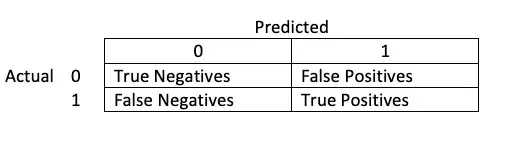


### statsmodels

In [108]:
def sm_log_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

    #X2_train = StandardScaler().fit_transform(X_train) non-robust when scaling
    #X2_test = StandardScaler().fit_transform(X_test)

    model = sm.Logit(y_train, X_train)
    results = model.fit()
    print(results.summary())
    print()

    y_preds = results.predict(X_test)
    score_model(y_test, y_preds)
    
    return results

In [109]:
for X in xlist:
    sm_log_reg(X, y)

Optimization terminated successfully.
         Current function value: 0.384300
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        offer completed   No. Observations:                36736
Model:                          Logit   Df Residuals:                    36728
Method:                           MLE   Df Model:                            7
Date:                Sat, 24 Dec 2022   Pseudo R-squ.:                  0.1622
Time:                        14:10:19   Log-Likelihood:                -14118.
converged:                       True   LL-Null:                       -16851.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                   0.0036      0.001      4.136      0.000       0.002       0.005
income  

In [110]:
results = sm_log_reg(X_rel, y)
summary_df = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0]
coeffs = summary_df['coef'].values

Optimization terminated successfully.
         Current function value: 0.384300
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        offer completed   No. Observations:                36736
Model:                          Logit   Df Residuals:                    36728
Method:                           MLE   Df Model:                            7
Date:                Sat, 24 Dec 2022   Pseudo R-squ.:                  0.1622
Time:                        14:10:20   Log-Likelihood:                -14118.
converged:                       True   LL-Null:                       -16851.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                   0.0036      0.001      4.136      0.000       0.002       0.005
income  

In [111]:
summary_df['real coeff'] = np.exp(summary_df['coef'])
summary_df

,coef,std err,z,P>|z|,[0.025,0.975],real coeff
age,0.00360,1.000000e-03,4.136,0.0,0.002000,0.005000,1.003606
income,0.00003,8.450000e-07,35.260,0.0,0.000028,0.000031,1.000030
female,0.64270,3.300000e-02,19.367,0.0,0.578000,0.708000,1.901608
membership months,0.07020,2.000000e-03,43.612,0.0,0.067000,0.073000,1.072723
bogo,-1.62050,6.400000e-02,-25.496,0.0,-1.745000,-1.496000,0.197800
discount 0.20,-1.52800,6.700000e-02,-22.779,0.0,-1.659000,-1.397000,0.216969
discount 0.25,-1.78290,7.200000e-02,-24.626,0.0,-1.925000,-1.641000,0.168150
discount 0.43,-1.26470,7.500000e-02,-16.965,0.0,-1.411000,-1.119000,0.282324


the p values for all features are 0 -> all selected coefficients of X_rel are statistically siginificant.

### sklearn

#### Quick comparison sklearn LogisticRegression

In [112]:
pipeline = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression())])
pipeline.steps

[('scale', StandardScaler()), ('clf', LogisticRegression())]

In [113]:
pipeline.set_params(clf = LogisticRegression())

def sklearn_log_reg(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    pipeline.fit(X_train, y_train)
    y_preds = pipeline.predict(X_test)
    score_model(y_test, y_preds)

In [114]:
for X in xlist:
    sklearn_log_reg(X,y)

0.8367346938775511 (Precision)
0.9820548367221196 (Recall)
0.827172256097561 (Accuracy)
[[  272  2488]
 [  233 12751]]
               precision    recall  f1-score   support

not completed       0.54      0.10      0.17      2760
    completed       0.84      0.98      0.90     12984

     accuracy                           0.83     15744
    macro avg       0.69      0.54      0.54     15744
 weighted avg       0.78      0.83      0.77     15744

0.8368137641187287 (Precision)
0.9814386937769563 (Recall)
0.826854674796748 (Accuracy)
[[  275  2485]
 [  241 12743]]
               precision    recall  f1-score   support

not completed       0.53      0.10      0.17      2760
    completed       0.84      0.98      0.90     12984

     accuracy                           0.83     15744
    macro avg       0.68      0.54      0.54     15744
 weighted avg       0.78      0.83      0.77     15744

0.8352001048012052 (Precision)
0.9820548367221196 (Recall)
0.8253938008130082 (Accuracy)
[[  244

#### model comparisons

we will choose X_res to proceed

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_rel, y, test_size = .30, random_state=42)

In [116]:
# selection of models inspired by: https://www.kaggle.com/code/gautham11/building-a-scikit-learn-classification-pipeline/notebook
clfs = []
clfs.append(LogisticRegression())
clfs.append(SVC())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier())
clfs.append(GradientBoostingClassifier())

for classifier in clfs:
    print(classifier)
    pipeline.set_params(clf = classifier)
    pipeline.fit(X_train, y_train)
    y_preds = pipeline.predict(X_test)
    score_model(y_test, y_preds)

LogisticRegression()
0.8367346938775511 (Precision)
0.9820548367221196 (Recall)
0.827172256097561 (Accuracy)
[[  272  2488]
 [  233 12751]]
               precision    recall  f1-score   support

not completed       0.54      0.10      0.17      2760
    completed       0.84      0.98      0.90     12984

     accuracy                           0.83     15744
    macro avg       0.69      0.54      0.54     15744
 weighted avg       0.78      0.83      0.77     15744

SVC()
0.8247887681849946 (Precision)
0.9999229821318546 (Recall)
0.8247586382113821 (Accuracy)
[[    2  2758]
 [    1 12983]]
               precision    recall  f1-score   support

not completed       0.67      0.00      0.00      2760
    completed       0.82      1.00      0.90     12984

     accuracy                           0.82     15744
    macro avg       0.75      0.50      0.45     15744
 weighted avg       0.80      0.82      0.75     15744

KNeighborsClassifier(n_neighbors=3)
0.8917131178000743 (Precision)
0

DecisionTree looks promising as a classifier, thus we select this one to run GridSearchCV for tuning hyperparameters:

In [117]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}  # parameter taken from: https://medium.com/analytics-vidhya/decisiontree-classifier-working-on-moons-dataset-using-gridsearchcv-to-find-best-hyperparameters-ede24a06b489
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [118]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=96, random_state=42)

In [119]:
pipeline.set_params(clf = grid_search_cv.best_estimator_)
pipeline.fit(X_train, y_train)
y_preds = pipeline.predict(X_test)
score_model(y_test, y_preds)

0.8527121191419593 (Precision)
0.9613370301910044 (Recall)
0.8311737804878049 (Accuracy)
[[  604  2156]
 [  502 12482]]
               precision    recall  f1-score   support

not completed       0.55      0.22      0.31      2760
    completed       0.85      0.96      0.90     12984

     accuracy                           0.83     15744
    macro avg       0.70      0.59      0.61     15744
 weighted avg       0.80      0.83      0.80     15744



In [125]:
pipeline.set_params(clf = DecisionTreeClassifier())
model = pipeline.fit(X_train, y_train)
y_preds = pipeline.predict(X_test)
score_model(y_test, y_preds)

0.9645002310180194 (Precision)
0.964648798521257 (Recall)
0.9415650406504065 (Accuracy)
[[ 2299   461]
 [  459 12525]]
               precision    recall  f1-score   support

not completed       0.83      0.83      0.83      2760
    completed       0.96      0.96      0.96     12984

     accuracy                           0.94     15744
    macro avg       0.90      0.90      0.90     15744
 weighted avg       0.94      0.94      0.94     15744



since the GridSearchCV optimized version of the model scores worse than with the default hyperparameters, we will keep the default model, which scores quite high.

In [135]:
# inspired by: https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
tree_rules = export_text(pipeline['clf'], feature_names=list(X_rel.columns))
print(tree_rules)

|--- membership months <= -0.39
|   |--- income <= 0.28
|   |   |--- female <= 0.16
|   |   |   |--- income <= -0.82
|   |   |   |   |--- membership months <= -0.90
|   |   |   |   |   |--- income <= -1.01
|   |   |   |   |   |   |--- discount 0.25 <= 1.13
|   |   |   |   |   |   |   |--- age <= -1.95
|   |   |   |   |   |   |   |   |--- membership months <= -1.19
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- membership months >  -1.19
|   |   |   |   |   |   |   |   |   |--- income <= -1.15
|   |   |   |   |   |   |   |   |   |   |--- discount 0.20 <= 0.58
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- discount 0.20 >  0.58
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- income >  -1.15
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- age >  -1.95
|   |   |   |   |

TypeError: 'str' object is not callable

<Figure size 1800x1440 with 0 Axes>